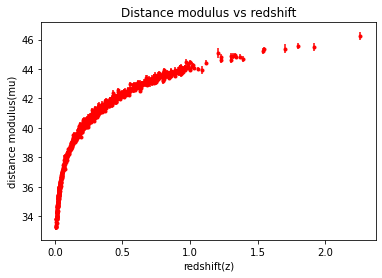

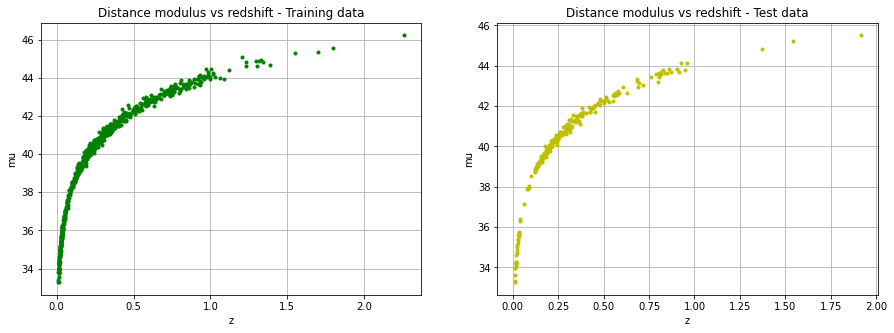

AttributeError: 'Series' object has no attribute 'strides'

AttributeError: 'Series' object has no attribute 'strides'

In [5]:
%run 01_DataPreparation.ipynb

In [7]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

In [ ]:
# hyperparameters
BATCH_SIZE = 10
EPOCHS = 10000
sequence_len = 4
n_features = 1 
# number of neurons in LSTM
num_units = 100

In [ ]:
TRAIN_LENGTH = len(z_train)
#TEST_LENGTH = len(z_test)
VAL_LENGTH = len(z_val)

In [ ]:
TRAIN_LENGTH

461

In [ ]:
# prepare data generators using tf.data
train_dataset = tf.data.Dataset.from_tensor_slices((z_train,mu_train)).shuffle(TRAIN_LENGTH, reshuffle_each_iteration=True).batch(BATCH_SIZE)
#test_dataset = tf.data.Dataset.from_tensor_slices((z_test,mu_test)).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((z_val,mu_val)).batch(BATCH_SIZE)

In [ ]:
def my_model(dropout_p=0.2):

    inputs = layers.Input((sequence_len, n_features))
    x = inputs

    x = layers.LSTM(100, return_sequences=True) (x)
    #x = layers.BatchNormalization() (x)
    x = layers.Dropout(dropout_p) (x)

    x = layers.LSTM(100, return_sequences=True) (x)
    #x = layers.BatchNormalization() (x)
    x = layers.Dropout(dropout_p) (x)

    x = layers.Dense(1) (x)

    return Model(inputs=inputs, outputs=x)

In [ ]:
model = my_model()

In [ ]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 4, 1)]            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 4, 100)            40800     
_________________________________________________________________
dropout_8 (Dropout)          (None, 4, 100)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 4, 100)            80400     
_________________________________________________________________
dropout_9 (Dropout)          (None, 4, 100)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 4, 1)              101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_____________________________________________________

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss=tf.keras.losses.MeanSquaredError(), metrics=tf.keras.metrics.RootMeanSquaredError())

In [ ]:
# Create a callback that saves the model's weights
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(runDir,'cp_union2_1.hdf5'), 
    monitor='val_loss', 
    save_weights_only=True, 
    verbose=1, 
    save_best_only=True
    )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=10, verbose=1,
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=1e-10
)

early_stopping = [
    tf.keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=0,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=2000,
        verbose=1
    )
]

model_history = model.fit(train_dataset,
                          epochs=EPOCHS,
                          validation_data=val_dataset,
                          callbacks=[checkpoint, early_stopping]
                          )

Epoch 1/10000
47/47 [==============================] - 0s 9ms/step - loss: 0.1128 - root_mean_squared_error: 0.3359 - val_loss: 0.0881 - val_root_mean_squared_error: 0.2968

Epoch 00001: val_loss improved from inf to 0.08806, saving model to /content/drive/MyDrive/M.Tech Thesis/Model independently calibrating the luminosity correlations of gamma ray bursts using deep learning/run/061620/cp_union2_1.hdf5
Epoch 2/10000
47/47 [==============================] - 0s 9ms/step - loss: 0.1092 - root_mean_squared_error: 0.3305 - val_loss: 0.0851 - val_root_mean_squared_error: 0.2918

Epoch 00002: val_loss improved from 0.08806 to 0.08514, saving model to /content/drive/MyDrive/M.Tech Thesis/Model independently calibrating the luminosity correlations of gamma ray bursts using deep learning/run/061620/cp_union2_1.hdf5
Epoch 3/10000
47/47 [==============================] - 0s 9ms/step - loss: 0.1095 - root_mean_squared_error: 0.3310 - val_loss: 0.0868 - val_root_mean_squared_error: 0.2946

Epoch 00

KeyboardInterrupt: ignored

In [ ]:
model.load_weights(os.path.join(runDir, 'cp_union2_1.hdf5'))

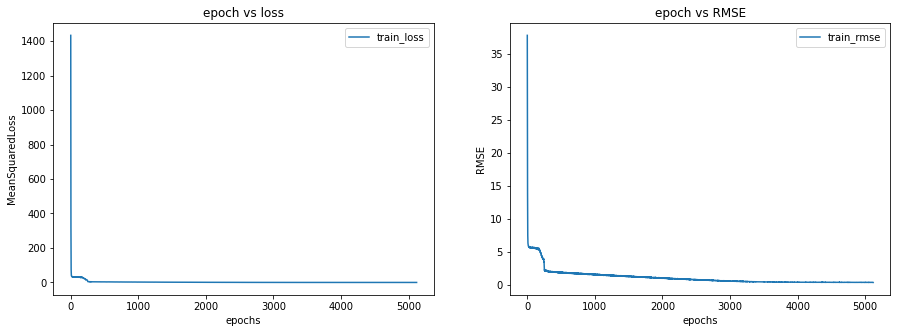

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot epoch vs loss, epoch vs RMSE
plt.figure(figsize=(15,5))

epochs = len(model_history.history['loss'])

plt.subplot(1,2,1)
plt.plot(np.arange(0,epochs,1), model_history.history['loss'], '-', label='train_loss')
#plt.plot(np.arange(0,epochs,1), model_history.history['val_loss'], '--', label='val_loss', )
plt.xlabel('epochs')
plt.ylabel('MeanSquaredLoss')
plt.title('epoch vs loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(np.arange(0,epochs,1), model_history.history['root_mean_squared_error'], '-', label='train_rmse')
#plt.plot(np.arange(0,epochs,1), model_history.history['val_root_mean_squared_error'], '--', label='val_rmse')
plt.xlabel('epochs')
plt.ylabel('RMSE')
plt.title('epoch vs RMSE')
plt.legend()
plt.show()

plt.savefig(os.path.join(runDir,'epoch_vs_loss.png'))

In [ ]:
#model.evaluate(test_dataset)

In [ ]:
# Reconstruct 
z_reconstruct = np.linspace(0,8.5,100)
z_reconstruct = np.expand_dims(strided_app(z_reconstruct, 4, 4), axis=-1)

In [ ]:
mu_reconstruct = model.predict(z_reconstruct)

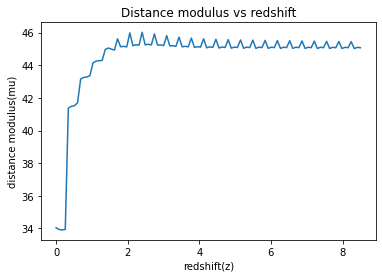

In [ ]:
# plot reconstructed z vs mu
plt.plot(z_reconstruct.flatten(), mu_reconstruct.flatten());
plt.xlabel('redshift(z)')
plt.ylabel('distance modulus(mu)')
plt.title('Distance modulus vs redshift')
plt.show()

In [ ]:
# estimate uncertainity by applying dropout n times

In [ ]:
def model_uncertainity(dropout_p=0.2):

    inputs = layers.Input((sequence_len, n_features))
    x = inputs
    
    x = layers.LSTM(100, return_sequences=True) (x)
    #x = layers.BatchNormalization() (x)
    x = layers.Dropout(dropout_p) (x, training=True)

    x = layers.LSTM(100, return_sequences=True) (x)
    #x = layers.BatchNormalization() (x)
    x = layers.Dropout(dropout_p) (x, training=True)

    x = layers.Dense(1) (x)

    return Model(inputs=inputs, outputs=x)

In [ ]:
model_uncertainity = model_uncertainity()

In [ ]:
model_uncertainity.load_weights(os.path.join(runDir,'cp_union2_1.hdf5'))

In [ ]:
model_uncertainity.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss=tf.keras.losses.MeanSquaredError(), metrics=tf.keras.metrics.RootMeanSquaredError())

In [ ]:
mu_reconstruct_uncertainity = []
n = 1000
for i in range(n):
    mu_reconstruct_uncertainity.append(model_uncertainity.predict(z_reconstruct, batch_size=128).flatten())

mu_reconstruct_uncertainity = np.array(mu_reconstruct_uncertainity)
mean = np.mean(mu_reconstruct_uncertainity, axis=0)
std_dev = np.std(mu_reconstruct_uncertainity, axis=0)

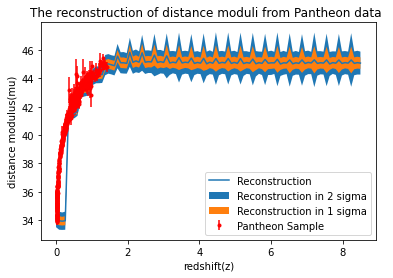

In [ ]:
plt.fill_between(z_reconstruct.flatten(), mean-2*std_dev, mean+2*std_dev,label='Reconstruction in 2 sigma')
plt.fill_between(z_reconstruct.flatten(), mean-1*std_dev, mean+1*std_dev,label='Reconstruction in 1 sigma')

plt.plot(z_reconstruct.flatten(), mean, label='Reconstruction')
plt.errorbar(z, mu, yerr=mu_err, fmt='.r', label='Pantheon Sample');
plt.xlabel('redshift(z)')
plt.ylabel('distance modulus(mu)')
plt.title('The reconstruction of distance moduli from Pantheon data ')
plt.legend()
plt.show()

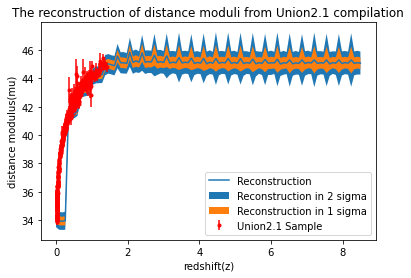

In [ ]:
plt.fill_between(z_reconstruct.flatten(), mean-2*std_dev, mean+2*std_dev,label='Reconstruction in 2 sigma')
plt.fill_between(z_reconstruct.flatten(), mean-1*std_dev, mean+1*std_dev,label='Reconstruction in 1 sigma')

plt.plot(z_reconstruct.flatten(), mean, label='Reconstruction')
plt.errorbar(z, mu, yerr=mu_err, fmt='.r', label='Union2.1 Sample');
plt.xlabel('redshift(z)')
plt.ylabel('distance modulus(mu)')
plt.title('The reconstruction of distance moduli from Union2.1 compilation')
plt.legend()
plt.show()